<a href="https://colab.research.google.com/github/BrainConnection/QuTiP/blob/main/Project%20Dynamic%20Decoupling/CP%20CPMG%20UDD%20Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [1]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 45.1 MB/s eta 0:00:00


In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


#6. X Pulse Drive

### 0) Functions

In [208]:
# time-dependent coefficient for drive

# args

# A (amplitude)
# Omega_rd (frequency)
# Phi (phase)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP/CPMG, 1: UDD)

def Hrd_env(t, args):

    A = args['A']
    Omega_rd = args['Omega_rd']
    Phi = args['Phi']
    T = args['T']
    N = args['N']
    Env = args['Env']
    Func = args['Func']

    # pulse time list
    # pi/2 pulse at T_srt, T_end
    # pi pulse at pulse time list

    Pulse_Time_List = []




    pulse = A * (0 <= t) * (t <= T)
    pulse = pulse + A * (2*T <= t) * (t <= 3*T)
    return pulse

def Hrd_coeff(t, args):

    A = args['A']
    Omega_rd = args['Omega_rd']
    Phi = args['Phi']
    T = args['T']
    N = args['N']
    Env = args['Env']
    Func = args['Func']

    return Hrd_env(t, args) * np.cos(omega_rd * t)

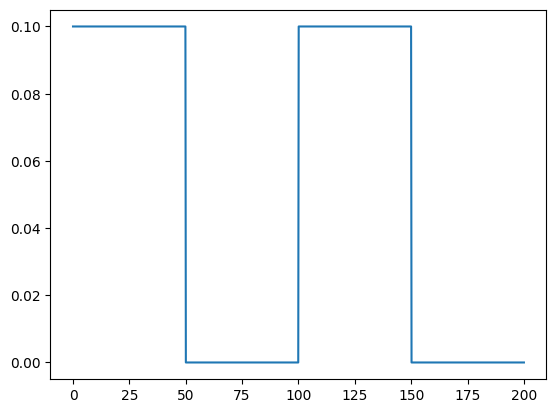

In [210]:
tlist = np.linspace(0, 200, 1000)

# list of times for numerical simulation (in units of ns)
plt.figure()
plt.plot(tlist, Hrd_env(tlist, {'A': 0.1, 'Phi': 0, 'T': 50, 'N': 0, 'Env': 0, 'Func': 0}))

###1) Qubit not coupled with Resonator (Rotating Frame)

$H = -\frac{\omega_q}{2}\sigma_z + A\sigma_x\cos{(\omega_{rot} t)} $

In [ ]:
# Basic parameters

omega_q = 2 * np.pi * 6.0  # resonator frequency in units of GHz
omega_rot = 2 * np.pi * 3.0  # qubit frequency in units of GHz

tlist = np.linspace(0, 100, 1000)

In [ ]:
# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()

H0 = -0.5*omega_q*sz

op_list = [sx, sy, sz]

In [ ]:
# time-dependent coefficient for drive
def Hrd_env(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T = args['T'] # duration of the readout drive, in units of ns

    return A * (0 <= t) * (t <= T)

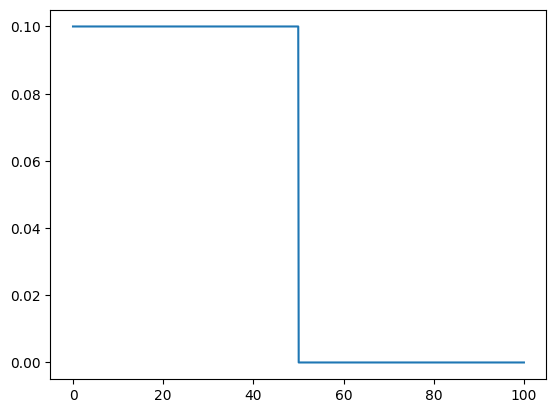

In [ ]:
# list of times for numerical simulation (in units of ns)
plt.figure()
plt.plot(tlist, Hrd_env(tlist, {'A': 0.1, 'T': 50, 'omega_rot': omega_rot}))

In [ ]:
result0 = mesolve(
    [sx, Hrd_env],
    basis(2,0),
    tlist,
    args = {'A': 0.1*np.pi, 'T': 5, 'omega_rot': omega_rot},
    e_ops = op_list,
    options = Options(nsteps = 1000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

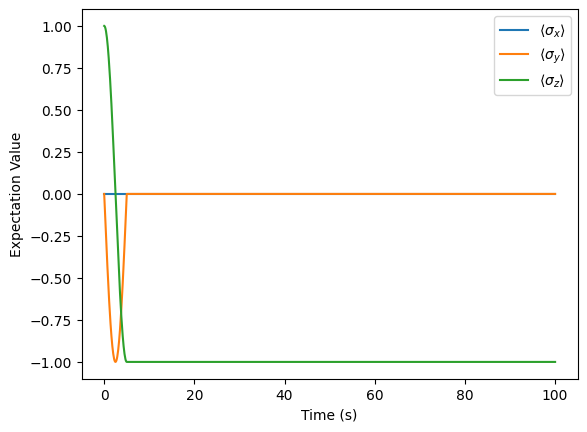

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result0.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, result0.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result0.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

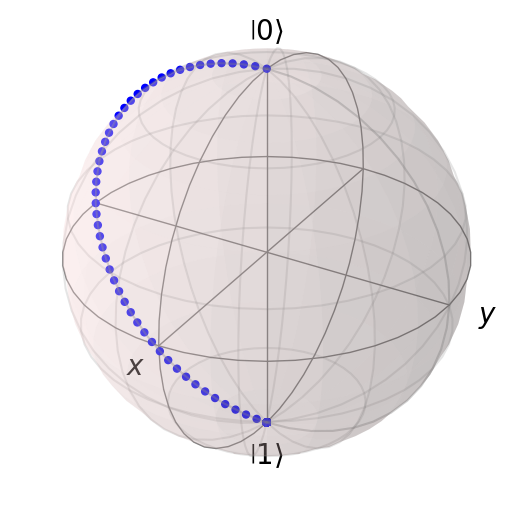

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result0.expect, meth="s")
sphere.show()

###2) Qubit not coupled with Resonator (Lab Frame)

$H = -\frac{\omega_q}{2}\sigma_z + A\sigma_x\cos{(\omega_{rot} t)} $

In [199]:
# Basic parameters

omega_q = 2 * np.pi * 6.0  # resonator frequency in units of GHz
omega_rd = 2 * np.pi * 6.0  # qubit frequency in units of GHz

tlist = np.linspace(0, 0.3, 10000)

In [200]:
# operator

sz = sigmaz()
sx = sigmax()
sy = sigmay()

H0 = -0.5*omega_q*sz

op_list = [sx, sy, sz]

In [201]:
# time-dependent coefficient for drive

def Hrd_env_ramsey(t, args):
    A = args['A'] # amplitude of the readout drive
    T = args['T'] # duration of the readout drive, in units of ns

    return A * (0 <= t) * (t <= T)

def Hrd_coeff_ramsey(t, args):
    omega_rd = args['omega_rd']
    return Hrd_env(t, args) * np.cos(omega_rd * t)

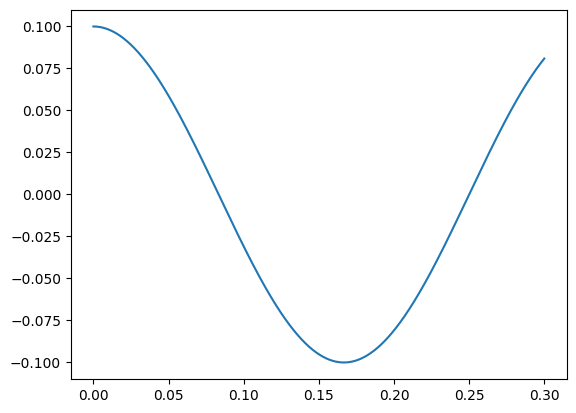

In [202]:
# list of times for numerical simulation (in units of ns)
plt.figure()
plt.plot(tlist, Hrd_coeff(tlist, {'A': 0.1, 'T': 200, 'omega_rd': omega_rd}))

In [203]:
result0 = mesolve(
    [H0, [sx, Hrd_coeff]],
    basis(2,0),
    tlist,
    args = {'A': 10*np.pi, 'T': 0.5, 'omega_rd': omega_rd},
    e_ops = op_list,
    options = Options(nsteps = 1000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

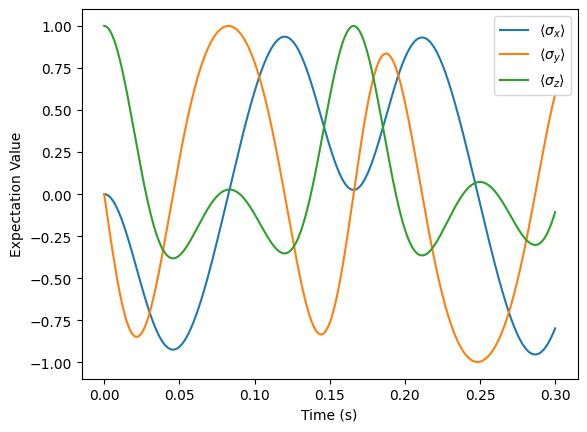

In [204]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result0.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, result0.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result0.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

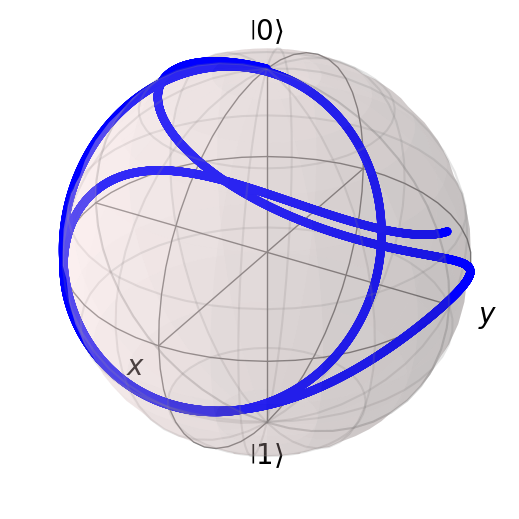

In [205]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result0.expect, meth="s")
sphere.show()